--- Setup: Loading libraries ---

--- 1. Loading Processed Data ---
Processed data and target variable loaded successfully.
Shape of features (X): (7043, 46)
Shape of target (y): (7043,)

--- 2. Splitting Data into Training and Test Sets ---
Training set size: 5634 samples
Test set size: 1409 samples

--- 3. Training the XGBoost Classifier ---
Calculated scale_pos_weight for class imbalance: 2.77
Training the model...
Model training complete. ✓

--- 4. Evaluating Model Performance ---
Model Accuracy: 0.9744

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.99      0.98      0.98      1035
   Churn (1)       0.94      0.96      0.95       374

    accuracy                           0.97      1409
   macro avg       0.97      0.97      0.97      1409
weighted avg       0.97      0.97      0.97      1409

Generating Confusion Matrix...


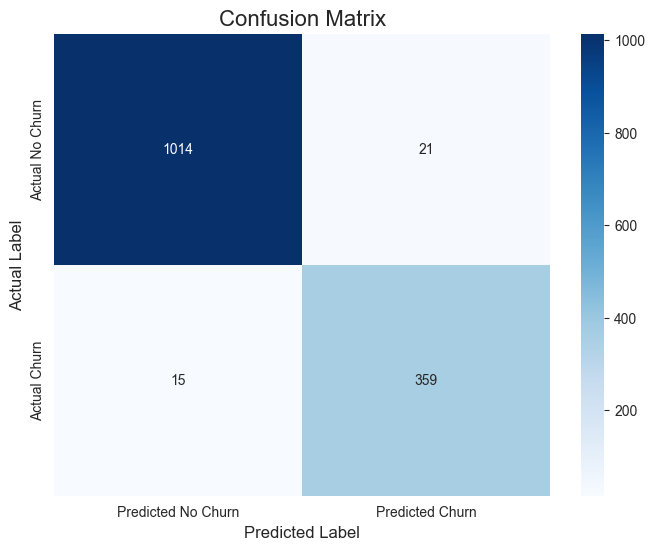


--- 5. Saving the Trained Model ---
Trained XGBoost model saved to 'churn_model.pkl'

Model training and evaluation process is complete.


In [4]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Setup ---
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print("--- Setup: Loading libraries ---")

# --- 1. Load Processed Data ---
print("\n--- 1. Loading Processed Data ---")
try:
    X_processed = joblib.load('X_processed.pkl')
    y = joblib.load('y_target.pkl')
    print("Processed data and target variable loaded successfully.")
    print(f"Shape of features (X): {X_processed.shape}")
    print(f"Shape of target (y): {y.shape}")
except FileNotFoundError:
    print("Error: Processed data files not found. Please run '02_feature_engineering_and_preprocessing.py' first.")
    exit()

# --- FIX: Ensure Target Variable is Numeric ---
# This makes the script robust even if the input 'y' is in string format ('Yes'/'No')
if y.dtype == 'object':
    print("Target variable is of type 'object'. Converting 'Yes'/'No' to 1/0...")
    y = y.map({'Yes': 1, 'No': 0})
    print("Conversion complete. ✓")

# --- 2. Split Data into Training and Testing Sets ---
print("\n--- 2. Splitting Data into Training and Test Sets ---")
# We use stratify=y to ensure the proportion of churned vs. non-churned customers is the same in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, 
    test_size=0.2,       # 20% of data will be used for testing
    random_state=42,     # for reproducibility
    stratify=y           # Important for imbalanced datasets
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# --- 3. Train the XGBoost Model ---
print("\n--- 3. Training the XGBoost Classifier ---")

# Handle class imbalance. The ratio is calculated as count(negative_class) / count(positive_class)
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
print(f"Calculated scale_pos_weight for class imbalance: {scale_pos_weight:.2f}")

# Initialize the XGBoost classifier
# Key parameters:
# - objective='binary:logistic': for binary classification
# - scale_pos_weight: to handle imbalance
# - use_label_encoder=False, eval_metric='logloss': to align with modern XGBoost standards
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model on the training data
print("Training the model...")
xgb_classifier.fit(X_train, y_train)
print("Model training complete. ✓")

# --- 4. Evaluate the Model ---
print("\n--- 4. Evaluating Model Performance ---")

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
# The report shows precision, recall, and F1-score for each class
print(classification_report(y_test, y_pred, target_names=['No Churn (0)', 'Churn (1)']))

# Generate and plot the confusion matrix
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# --- 5. Save the Trained Model ---
print("\n--- 5. Saving the Trained Model ---")
joblib.dump(xgb_classifier, 'churn_model.pkl')
print("Trained XGBoost model saved to 'churn_model.pkl'")

print("\nModel training and evaluation process is complete.")
